# Conformalized Survival Regression

In this notebook we'll explore survival prediction in a classical setting, survival prediction under incomplete censoring times, and our proposed remedy for incomplete censoring times, using our novel technique.

First we need a baseline. In the classical case of Type I censoring, for every patient there is a triplet $(X,C,T)$, of which we have access to $(X,\tilde{T}=C\wedge T, T)$.
We'll use the same random generation process as Candes et. al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv
from sklearn.dummy import DummyRegressor



In [2]:
n_samples = 10000
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()
X_multi = np.random.uniform(low=-1.0, high=1.0, size=(n_samples, 100))
# C_uni = X_uni/2
C_uni = np.random.exponential(10, size=n_samples) * X_uni
# C_uni = np.random.exponential(10, size=n_samples)
C_multi = np.random.exponential(10, size=n_samples) * (X_multi[:,0] + 1) 
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5
sd_uni_hetero = 1 + X_uni/5

T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C_uni), np.minimum(T_uni_homo, C_uni))
T_uni_hetero = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_hetero, size=n_samples))
T_tilde_uni_hetero = Surv.from_arrays((T_uni_hetero < C_uni), np.minimum(T_uni_hetero, C_uni))
T_tilde_uni_hetero = np.minimum(T_uni_hetero, C_uni)

mu_multi = np.log(2) + 1 + 0.55 * (X_multi[:,0]**2 + X_multi[:,2] * X_multi[:,4])
sd_multi_homo = 1
sd_multi_hetero = np.abs(X_multi[:,9]) + 1

T_multi_homo = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_homo, size=n_samples))
T_tilde_multi_homo = Surv.from_arrays((T_multi_homo < C_multi), np.minimum(T_multi_homo, C_multi))
T_multi_hetero = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_hetero, size=n_samples))
T_tilde_multi_hetero = Surv.from_arrays((T_multi_hetero < C_multi), np.minimum(T_multi_hetero, C_multi))

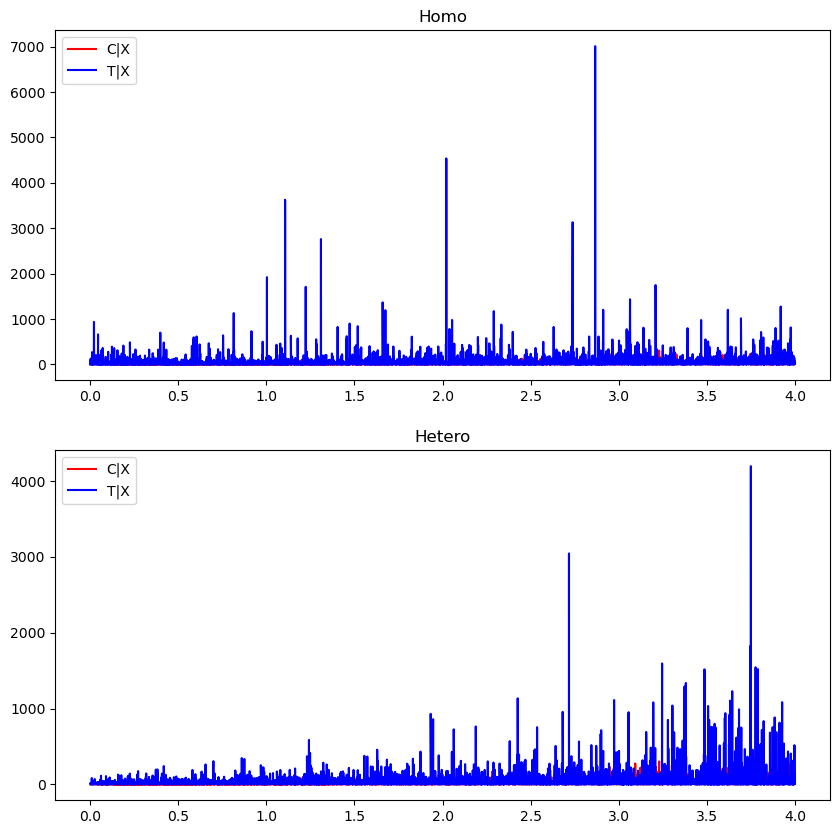

In [3]:
data_uncensored = [
    (X_uni, C_uni, T_uni_homo),
    (X_uni, C_uni, T_uni_hetero)
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, c, t = data_uncensored[i]
    axs[i].plot(x, c, color="red", label='C|X', )
    axs[i].plot(x, t, color="blue", label='T|X')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

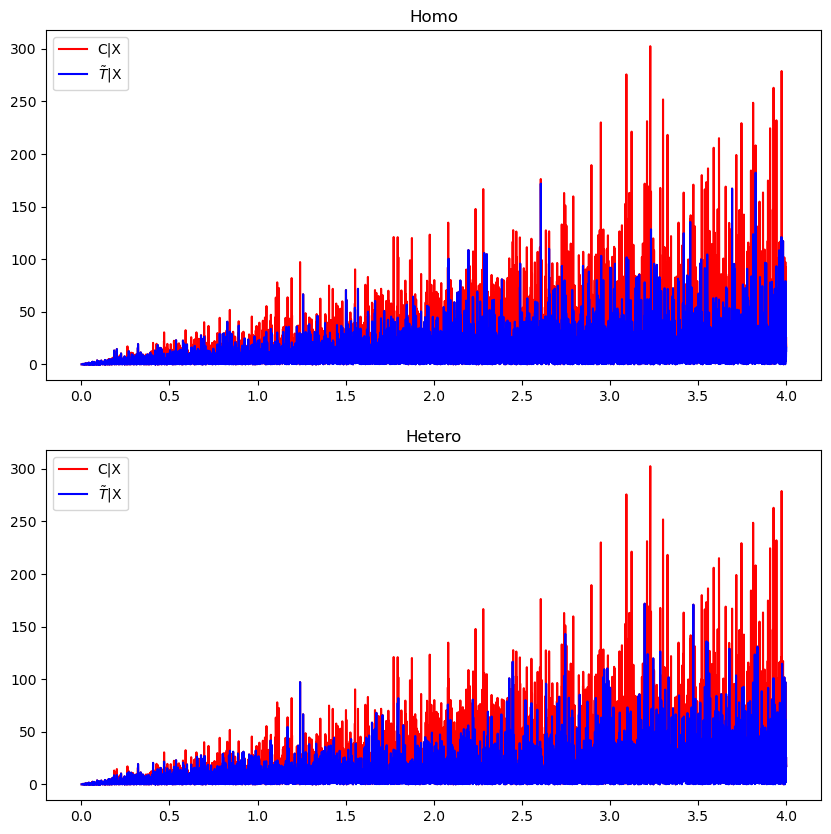

In [4]:
data_censored = [
    (X_uni, C_uni, np.minimum(T_uni_homo, C_uni)),
    (X_uni, C_uni, np.minimum(T_uni_hetero, C_uni))
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, c, t = data_censored[i]
    axs[i].plot(x, c, color="red", label='C|X', )
    axs[i].plot(x, t, color="blue", label=r'$\tilde{T}$|X')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

In [5]:
alpha = 0.1
betas = np.array([beta/10.0 for beta in range(1, 10, 1)])
X_uni_train, X_uni_test, C_train, C_test, T_uni_homo_train, T_uni_homo_test = train_test_split(X_uni, C_uni, T_uni_homo)
_, _, _, _,  T_uni_hetero_train, T_uni_hetero_test = train_test_split(X_uni, C_uni, T_uni_hetero)
X_multi_train, X_multi_test, _, _,  T_multi_hetero_train, T_multi_hetero_test = train_test_split(X_multi, C_multi, T_multi_hetero)
_, _, _, _,  T_multi_homo_train, T_multi_homo_test = train_test_split(X_multi, C_multi, T_multi_homo)

# Weighted Conformal

In [14]:
def non_conformity(y, y_hat):
    scores = np.append(y_hat - y['time'], np.inf)
    # print(f"actual y: {y['time']}")
    # print(f"y_hat: {y_hat}")
    scores.sort()
    return scores

def estimate_weights(betas, C_hat, c_0):
    # Step 1: Find where C_hat > c_0
    greater_than_c0 = C_hat > c_0

    # Step 2: Find the index of the first True value in each row
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)

    # Step 3: Select the corresponding betas
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

def oracle_weights(betas, X_cal, lamb, c_0):
    exp_quantiles = np.array([- np.log(1-b)/lamb for b in betas]).reshape(1,-1)
    greater_than_c0 = (X_cal * exp_quantiles) > c_0
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

# print(estimate_weights(np.array([0.1, 0.5 ,0.9]), np.array([[1, 2 ,3], [1, 3 ,5]]), 2.5)) # [10.  2.]

In [15]:
def cfsurv_c0(X_train, X_test, C_train, T_train, T_test, c_0, alpha):   
    # split the train data into training and calibration
    X_train, X_test, C_train, T_train, T_test = X_train.copy(), X_test.copy(), C_train.copy(), T_train.copy(), T_test.copy()
    T_tilde_train = Surv.from_arrays((T_train < C_train), np.minimum(T_train, C_train))
    C_train = C_train.astype([('event', '?'), ('time', '<f8')])
    T_tilde_train['time'] = np.minimum(T_tilde_train['time'], c_0)
    T_test = np.minimum(T_test, c_0)
    # print(f"T_test is: {T_test}")
    if len(X_train.shape) == 1 and len(X_test.shape) == 1:
        X_train = X_train.reshape(-1,1)
        X_test = X_test.reshape(-1,1)
    X_train, X_cal, C_train, C_cal, T_tilde_train, T_tilde_cal = train_test_split(X_train, C_train, T_tilde_train, train_size=X_train.shape[0]//2)
    
    # keep only data where C>=c_0
    T_tilde_cal, X_cal = T_tilde_cal[C_cal['time'] >= c_0].copy(), X_cal[C_cal['time'] >= c_0]
    # print(f'filtered calibration set size: {len(T_tilde_cal)}')
        
    # train a regression model on T: q_hat(x)
    T_est = GradientBoostingSurvivalAnalysis(loss="pinball", beta=1-alpha, learning_rate=1.0, max_depth=1, random_state=0)
    T_est.fit(X_train, T_tilde_train)
    
    # compute conformity score for each point in the calibration set
    T_cal_hat = T_est.predict(X_cal)
    scores = non_conformity(T_tilde_cal, T_cal_hat)
    
    # estimate the weight for each point in the calibration set
    betas = np.array([beta/100.0 for beta in range(1, 100, 1)])
    C_est = [GradientBoostingSurvivalAnalysis(loss="pinball", beta=b, learning_rate=0.1, max_depth=1, random_state=0) for b in betas]
    C_hat_cal = []
    C_hat_test = []
    for est in C_est:
        est.fit(X_train, C_train)
        C_hat_cal.append(est.predict(X_cal))
        C_hat_test.append(est.predict(X_test))
    
    C_hat_cal = np.transpose(np.array(C_hat_cal))
    C_hat_test = np.transpose(np.array(C_hat_test))
    
    w_cal = estimate_weights(betas, C_hat_cal, c_0)
    # w_cal = oracle_weights(betas, X_cal, 0.1, c_0)
    # print(f'w_cal_est shape: {w_cal_est.shape}, w_cal shape: {w_cal.shape}')
    
    # compute the weights for the test data
    w_test = estimate_weights(betas, C_hat_test, c_0)
    # w_test = oracle_weights(betas, X_test, 0.1, c_0)

    # compute propensity scores
    p_test = (w_test / (w_cal.sum() + w_test)).reshape(-1,1) # vector of length len(w_test)
    p_cal = w_cal.reshape(1,-1) / (w_cal.sum() + w_test.reshape(-1,1)) # size of (w_test, w_cal)
    p = np.concatenate([p_cal, p_test], axis=1)
    np.testing.assert_almost_equal(p[0].sum(),1, decimal=10) # f'propensity weights don\'t sum to 1, sum: {p[0].sum()}'

    # compute weighted quantiles for each test point
    cumulative_weights = np.cumsum(p, axis=1)
    np.testing.assert_almost_equal(p[-1].sum(), 1, decimal=10) # 'wrong cumsum axis'
    quantile_indices = np.argmax(cumulative_weights >= (1-alpha), axis=1)
    quantile_values = scores[quantile_indices]
    # print(f"scores: {scores}")
    # print(f"cumulative_weights: {cumulative_weights[0]}")
    # print(f"quantile_indices: {quantile_indices[0]}")
    # print(f"quantile_values: {quantile_values[0]}")
    # print(C_hat_cal)

    # compute LPB
    lpb = np.minimum(T_est.predict(X_test) - quantile_values, c_0)
    emp_coverage = (lpb <= T_test)
    emp_coverage = emp_coverage.sum()/len(emp_coverage)

    return lpb, emp_coverage, scores

# Univariate Homoscedastic

In [ ]:
lpb, emp_coverage, scores = cfsurv_c0(X_uni_train, X_uni_test, C_train, T_uni_homo_train, T_uni_homo_test, 10, 0.)
print(f"coverage is {emp_coverage}")
print(f"LPBs are {lpb}")

In [ ]:
pd.Series(scores[:-1]).hist()
print(pd.Series(scores).quantile(0.9))

In [16]:
# find c_0 for uni homo that gives the closest coverage to 1-alpha
c_0_vals = np.array(np.logspace(0,2,10))
coverage = []
for c_0 in c_0_vals:
    coverage_c_0 = 0
    for i in range(5):
        lpb, emp_coverage, scores = cfsurv_c0(X_uni_train, X_uni_test, C_train, T_uni_homo_train, T_uni_homo_test, c_0, 0.1)
        coverage_c_0 += emp_coverage
    coverage.append(coverage_c_0/5)

In [17]:
coverage

[0.96488,
 0.93208,
 0.9027199999999999,
 0.8959199999999999,
 0.89896,
 0.89032,
 0.9236000000000001,
 0.9468799999999999,
 0.9674400000000001,
 0.96936]

In [21]:
c_0_vals = np.array(np.logspace(np.log10(12.91549665),np.log10(21.5443469),10))
coverage = []
for c_0 in c_0_vals:
    coverage_c_0 = 0
    for i in range(5):
        lpb, emp_coverage, scores = cfsurv_c0(X_uni_train, X_uni_test, C_train, T_uni_homo_train, T_uni_homo_test, c_0, 0.1)
        coverage_c_0 += emp_coverage
    coverage.append(coverage_c_0/5)

In [23]:
coverage

[0.8817600000000001,
 0.9074399999999999,
 0.9044800000000001,
 0.8964000000000001,
 0.90384,
 0.8927999999999999,
 0.89832,
 0.8772,
 0.90768,
 0.90808]

In [22]:
c_0_opt = 13

In [25]:
coverage_uni_homo = []
coverage_c_0 = 0
for i in range(15):
    lpb, emp_coverage, scores = cfsurv_c0(X_uni_train, X_uni_test, C_train, T_uni_homo_train, T_uni_homo_test, c_0_opt, 0.1)
    coverage_uni_homo.append(emp_coverage)